In [1]:
import json

import torch
import numpy as np
import matplotlib.pyplot as plt
import transformers

from collections import defaultdict #, Counter
from transformers import AutoModelForMaskedLM, AutoTokenizer

from operator import mul
from functools import reduce

device = 'cuda:0'
softmax = torch.nn.Softmax(dim=-1)
torch.manual_seed(0)
np.random.seed(0)

MODEL_NAME = 'xlm-roberta-large'
MASK_TOKEN = '<mask>'
PAD_TOKEN = '<pad>'
BOS_TOKEN = '<s>'
EOS_TOKEN = '</s>'

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForMaskedLM.from_pretrained(MODEL_NAME)
device = torch.device('cuda:0')
model.to(device)
reverse_vocab = {y:x for x, y in tokenizer.vocab.items()}

In [2]:
# let's check the number of tokens in our keywords
keywords = ['что-либо', 'чего-либо', 'кто-либо', 'кого-либо']
keywords2tokens = dict()

for keyword in keywords:
    tokens = tokenizer.tokenize(keyword)
    keywords2tokens[keyword] = tokens
    print(len(tokens), tokens)

3 ['▁что', '-', 'либо']
3 ['▁чего', '-', 'либо']
3 ['▁кто', '-', 'либо']
3 ['▁кого', '-', 'либо']


In [5]:
# parse, mask, tokenize

subj_dict = dict()
verb_dict = dict()

def mask_sent(sent, kword):
    return [BOS_TOKEN,] + tokenizer.tokenize( 
        sent.replace(kword, f'{MASK_TOKEN} '*len(keywords2tokens[kword])).replace('  ',' ') 
    ) + [EOS_TOKEN,]

tokenized_array = []
metadata_array = []

for idx, line in enumerate(open('ru_test_sentences_libo.tsv', encoding='utf-8')):
    chunks = line.strip().split()
    tchunks = line.strip().split('\t')

    if chunks[-1]=='thing':
        kwords = ('что-либо','чего-либо','что-либо','что-либо',)
    else:
        kwords = ('кого-либо','кого-либо','кого-либо','кого-либо',)
    
    subj_id = int(chunks[-3])
    subject = chunks[1]
    subj_dict[subj_id] = subject
    verb_id = int(chunks[-2])
    verb1 = chunks[2]
    verb2 = chunks[8]
    verb_dict[verb_id] = (verb1, verb2)
    
    for tidx, (cl,kword) in enumerate( zip( ('aff', 'neg', 'many', 'few'), kwords ) ):
        mt_sent = mask_sent(tchunks[tidx], kword)
        tokenized_array.append( mt_sent )
        metadata_array.append( 
            (
                (cl, subj_id, verb_id, kword, chunks[-1]),
                (tchunks[tidx], mt_sent)
            )
        )


In [6]:
def assess_batch(batch, metas):
    batch_input_ids = []
    batch_segment_ids = []
    
    mask_positions = []
    mask_lens = []

    max_len = max(map(len,batch))
    
    for s in batch:
        mask_positions.append( s.index(MASK_TOKEN) )
        mask_lens.append( s.count(MASK_TOKEN) )
        
        input_ids = tokenizer.convert_tokens_to_ids(s + [PAD_TOKEN,]*(max_len-len(s)))
        batch_input_ids.append( input_ids )
        batch_segment_ids.append( [0] * len(input_ids) )

    input_ids = torch.tensor(batch_input_ids, dtype=torch.long).to(device)
    segment_ids = torch.tensor(batch_segment_ids, dtype=torch.long).to(device)
    logits = model(input_ids, token_type_ids=segment_ids)[0]
    probs = softmax(logits)
    
    return [
        reduce(mul, [pr[pos+t_pos][tokenizer.vocab[tok]].cpu().detach().numpy() \
            for t_pos, tok in enumerate(keywords2tokens[meta[0][3]]) ], 1. ) \
                for pr, pos, meta in zip(probs, mask_positions, metas)
    ]
        
assess_batch(tokenized_array[128*4:130*4], metadata_array[126*4:130*4])

[4.355815828248641e-09,
 6.350815966620901e-08,
 4.16049377673948e-10,
 1.2247098668579244e-08,
 2.3763461575482046e-13,
 5.278288756179465e-11,
 2.306754858410871e-11,
 5.245822246260154e-11]

In [7]:
# assess all the sentences

BATCH_SIZE = 40

scores = []
for idx in range(0, len(tokenized_array), BATCH_SIZE):
    if not idx%400: print(f'{idx/(len(tokenized_array)):.2%}')
    scores.extend( assess_batch(tokenized_array[idx:idx+BATCH_SIZE], metadata_array[idx:idx+BATCH_SIZE]) )

0.00%
1.00%
2.00%
3.00%
4.00%
5.00%
6.00%
7.00%
8.00%
9.00%
10.00%
11.00%
12.00%
13.00%
14.00%
15.00%
16.00%
17.00%
18.00%
19.00%
20.00%
21.00%
22.00%
23.00%
24.00%
25.00%
26.00%
27.00%
28.00%
29.00%
30.00%
31.00%
32.00%
33.00%
34.00%
35.00%
36.00%
37.00%
38.00%
39.00%
40.00%
41.00%
42.00%
43.00%
44.00%
45.00%
46.00%
47.00%
48.00%
49.00%
50.00%
51.00%
52.00%
53.00%
54.00%
55.00%
56.00%
57.00%
58.00%
59.00%
60.00%
61.00%
62.00%
63.00%
64.00%
65.00%
66.00%
67.00%
68.00%
69.00%
70.00%
71.00%
72.00%
73.00%
74.00%
75.00%
76.00%
77.00%
78.00%
79.00%
80.00%
81.00%
82.00%
83.00%
84.00%
85.00%
86.00%
87.00%
88.00%
89.00%
90.00%
91.00%
92.00%
93.00%
94.00%
95.00%
96.00%
97.00%
98.00%
99.00%


In [8]:
len(scores)

40000

In [9]:
# reshape scores
stats = defaultdict(lambda:defaultdict(lambda:defaultdict(float)))

for score, meta in zip(scores, metadata_array):
    if meta[0][0]=='aff':
        handle = (meta[0][4], 'aff>neg')
        k_idx = 0
    if meta[0][0]=='neg':
        handle = (meta[0][4], 'aff>neg')
        k_idx = 1
    if meta[0][0]=='many':
        handle = (meta[0][4], 'many>few')
        k_idx = 0
    if meta[0][0]=='few':
        handle = (meta[0][4], 'many>few')
        k_idx = 1
    stats[handle][(meta[0][1], meta[0][2])][k_idx] = score
    handle = ('both', handle[1])
    stats[handle][(meta[0][1], meta[0][2])][k_idx] += score


In [10]:
for handle in sorted(stats):
    print(handle, 
          f'  {np.count_nonzero(list(map(lambda x:x[0]>x[1], stats[handle].values())))/len(stats[handle].values()):0.3%}')

('body', 'aff>neg')   3.784%
('body', 'many>few')   16.715%
('both', 'aff>neg')   35.956%
('both', 'many>few')   12.005%
('thing', 'aff>neg')   44.437%
('thing', 'many>few')   11.626%


(array([2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 4.000e+00, 4.000e+00,
        7.000e+00, 1.500e+01, 6.400e+01, 7.498e+03]),
 array([-1.93083454e-06, -1.73332721e-06, -1.53581987e-06, -1.33831253e-06,
        -1.14080520e-06, -9.43297863e-07, -7.45790526e-07, -5.48283190e-07,
        -3.50775854e-07, -1.53268518e-07,  4.42388180e-08]),
 <BarContainer object of 10 artists>)

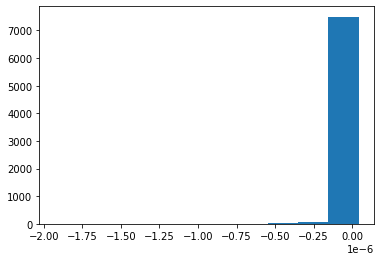

In [11]:
plt.hist(list(map(lambda x:x[0]-x[1],stats[('thing', 'many>few')].values())))

(array([1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        2.000e+00, 2.000e+00, 1.400e+01, 7.573e+03]),
 array([-9.50220019e-07, -8.53533111e-07, -7.56846202e-07, -6.60159294e-07,
        -5.63472386e-07, -4.66785477e-07, -3.70098569e-07, -2.73411661e-07,
        -1.76724752e-07, -8.00378441e-08,  1.66490642e-08]),
 <BarContainer object of 10 artists>)

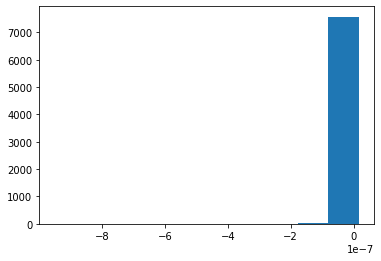

In [12]:
plt.hist(list(map(lambda x:x[0]-x[1],stats[('thing', 'aff>neg')].values())))